## Importing Libraries
This section imports all the required libraries for data manipulation, visualization, preprocessing, model training, and evaluation.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


## Load and Explore Dataset
This section loads the dataset from a URL and performs exploratory data analysis such as summary statistics

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

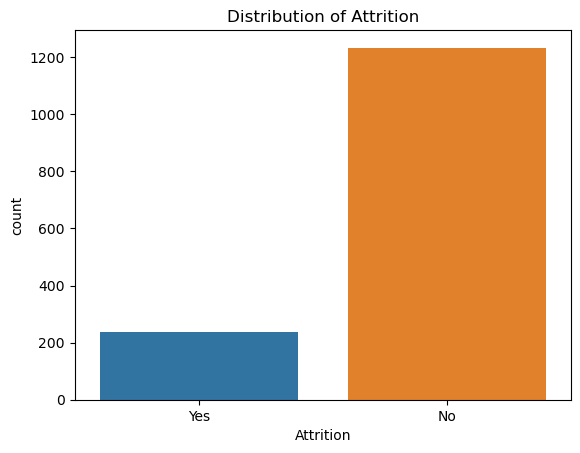

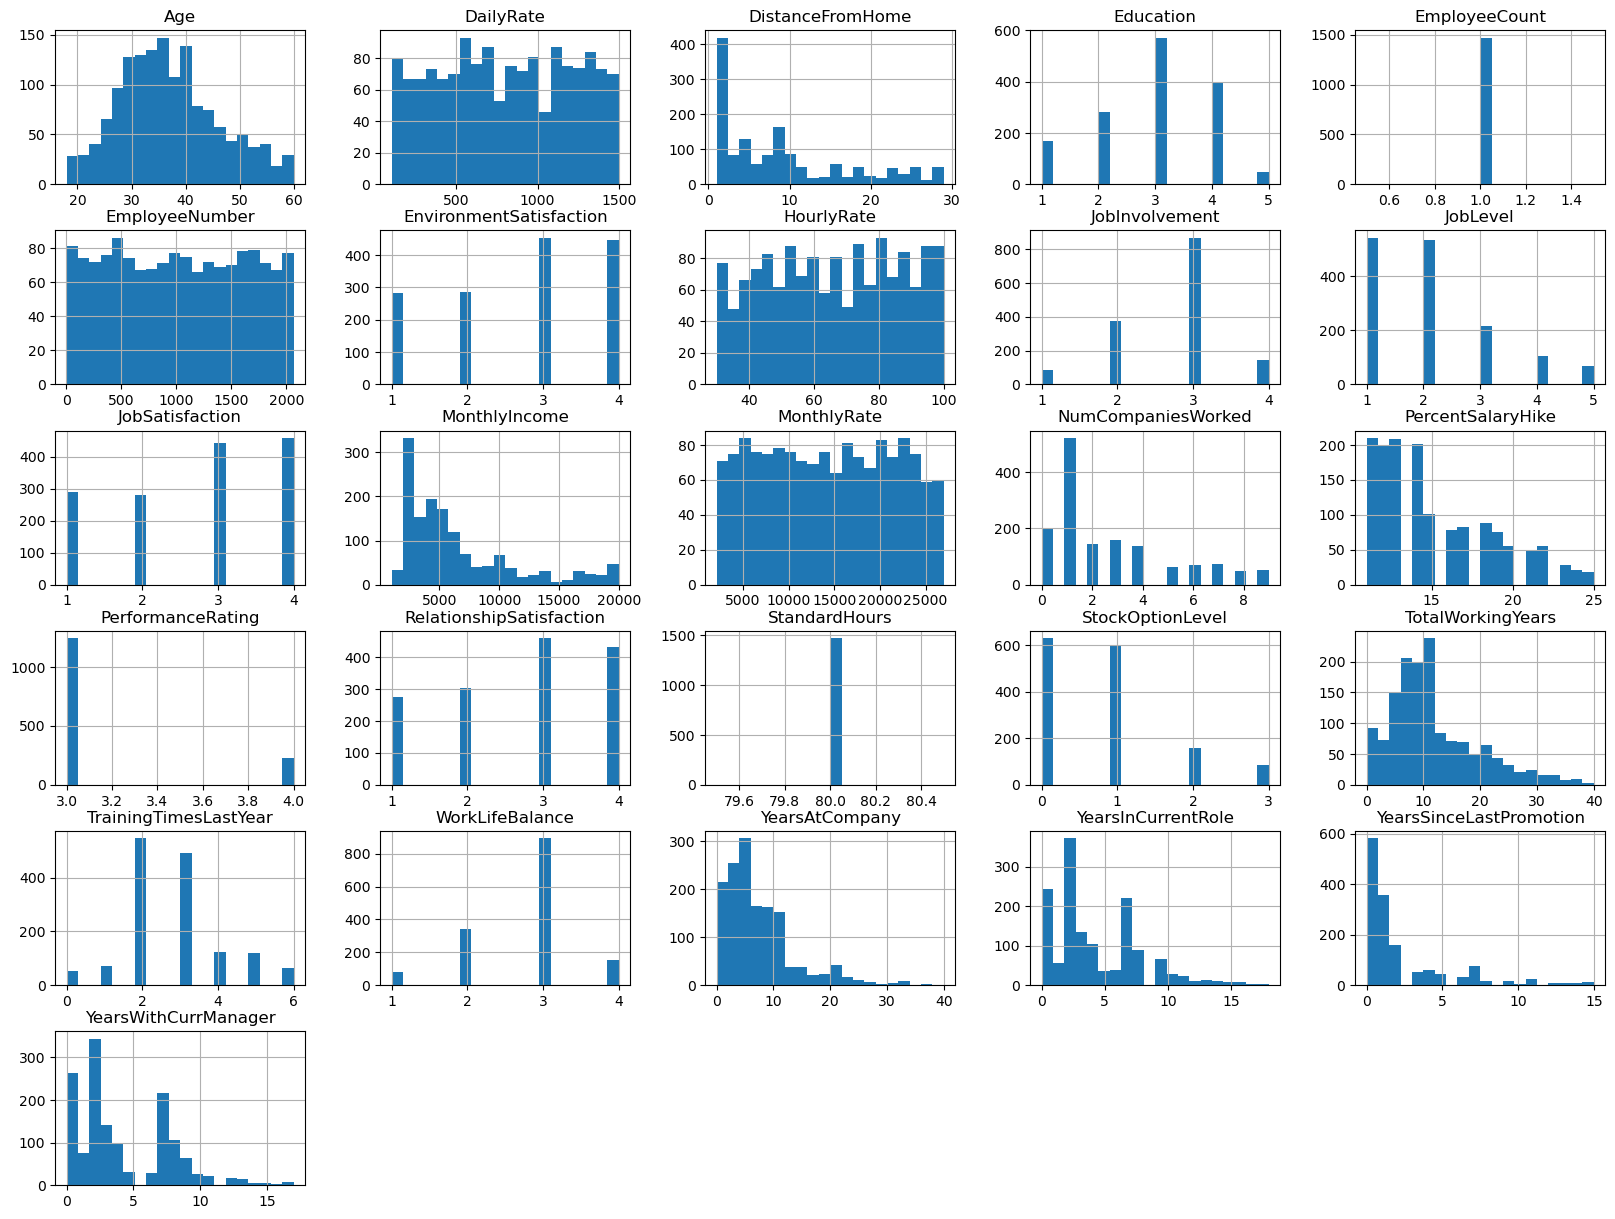

ValueError: num must be an integer with 1 <= num <= 25, not 26

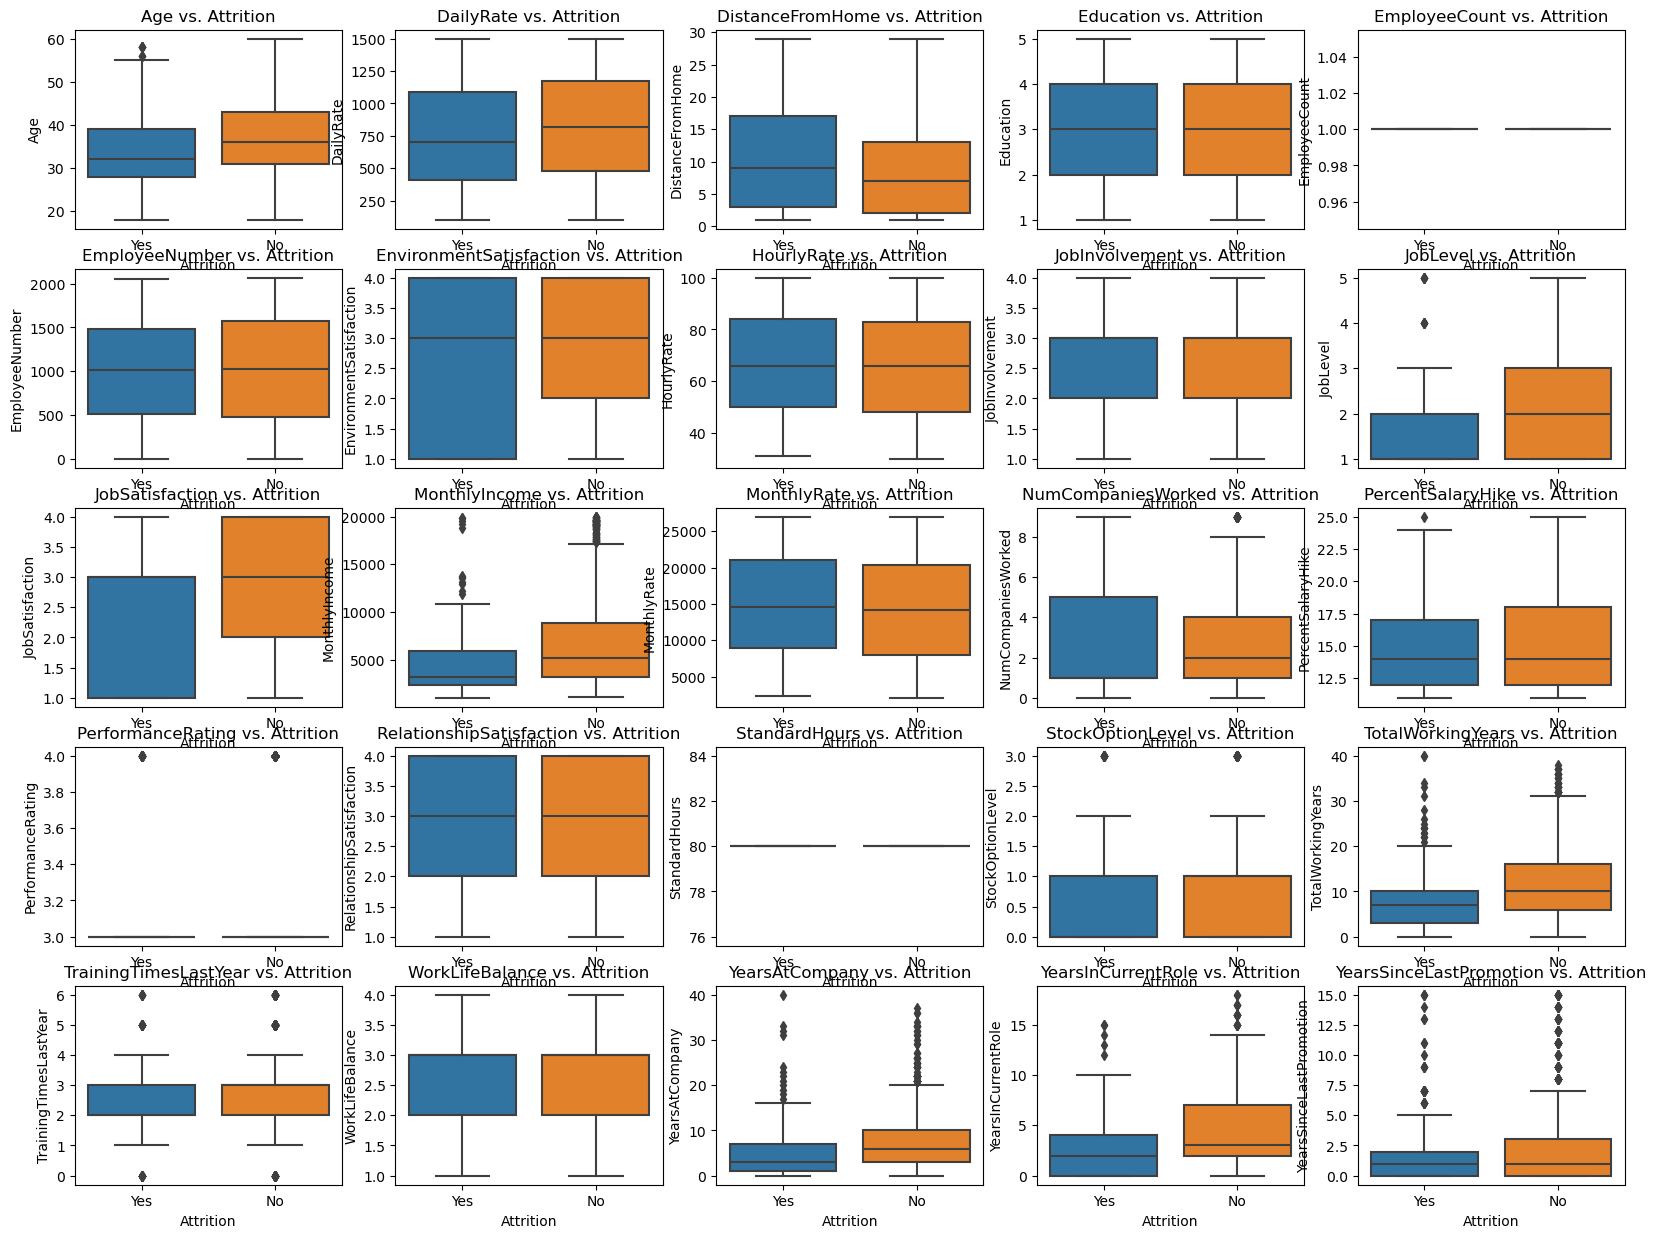

In [11]:
# Load the dataset
url = r"C:\Users\Sonymaths\Downloads\archive\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(url)

# Display the first few rows
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())





## Data Preprocessing
The numerical and categorical columns are identified based on their data types.Separate preprocessing pipelines are defined for numerical and categorical data. Numerical data is imputed with the median and scaled, while categorical data is imputed with the most frequent value and one-hot encoded.These preprocessing steps are combined using ColumnTransformer. The preprocessing transformations are applied to the features.
The data is split into training and test sets. Class imbalance in the training data is addressed using Synthetic Minority Over-sampling Technique (SMOTE) to create synthetic samples of the minority class.









In [ ]:
# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).drop(columns=['Attrition']).columns.tolist()

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the transformations
X = df.drop(columns=['Attrition'])
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X_processed = preprocessor.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


## Model Training and Hyperparameter Tuning
In this section, a Random Forest classifier is trained, and its hyperparameters are tuned using grid search with cross-validation. The best model obtained from the grid search is stored in best_rf, and its best parameters are printed.

In [ ]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=strat_kfold, scoring='f1', return_train_score=True)
grid_search_rf.fit(X_train_res, y_train_res)

# Best Random Forest model
best_rf = grid_search_rf.best_estimator_
print(f"Random Forest Best Params: {grid_search_rf.best_params_}")


## Model Evaluation
In this section, the best Random Forest model obtained from hyperparameter tuning is evaluated using various metrics such as accuracy, precision, recall, F1 score, and ROC-AUC score. Additionally, the classification report and confusion matrix are displayed to provide further insights into the model's performance.

In [ ]:
# Evaluate the best Random Forest model
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


##  Cross-Validation Results
In this section, cross-validation is performed using stratified k-fold validation. F1 scores are calculated for each fold, and then the mean and standard deviation of these F1 scores are computed and printed, providing insights into the model's performance and its consistency across different folds of the training data.

In [ ]:
# Cross-validation scores
cv_results = cross_val_score(best_rf, X_train_res, y_train_res, cv=strat_kfold, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_results}")
print(f"Mean CV F1 Score: {cv_results.mean():.4f}")
print(f"Standard Deviation of CV F1 Scores: {cv_results.std():.4f}")


In [ ]:
## Faeture Importance
This section analyzes the importance of features in the trained Random Forest model. It starts by obtaining the feature names after preprocessing, then extracts the feature importances from the Random Forest model. These importances are stored in a DataFrame along with their corresponding feature names. The DataFrame is sorted in descending order based on feature importance, and the top 10 features are displayed to provide insights into which features are most influential in the model's predictions.

In [ ]:
# Get feature names after preprocessing
num_features = numerical_cols
cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([num_features, cat_features])

# Get feature importances from the Random Forest model
feature_importances = best_rf.feature_importances_

# Create a DataFrame for feature importances
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Features:")
print(feat_importance_df.head(10))


In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()
